In [1]:
import sys
import os
import warnings

import gzip
import pickle

import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import savgol_filter

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions

warnings.filterwarnings('ignore')
# sys.path.append('../scripts/')
# from power_simulations import multivar_mixedeffects_linear_regression

In [2]:
import sys
sys.path.append('../../')
from consensus_variables import *

# parse source data

In [3]:
# define global variables

omega_truncating = f'{additional_data_dir}/power_data/omega.dnds_mle_truncating_allprof_uniquemuts_nosignificant.truncantinggenes.tsv'
omega_missense = f'{additional_data_dir}/power_data/omega.dnds_mle_missense_allprof_uniquemuts_nosignificant.missensegenes.tsv'
clinical_meta = clinvars_file

# Description of the cohort

In [4]:
df_clinical = pd.read_csv(clinical_meta, sep='\t')
cohort_size = df_clinical.SAMPLE_ID.unique().shape
number_of_donors = df_clinical.SUBJECT_ID.unique().shape

cohort_size_male = df_clinical[df_clinical['SEX'] == 'M'].SAMPLE_ID.unique().shape
number_of_donors_male = df_clinical[df_clinical['SEX'] == 'M'].SUBJECT_ID.unique().shape

cohort_size_smoking = df_clinical[df_clinical['HISTORY_OF_SMOKING'] == 'yes'].SAMPLE_ID.unique().shape
number_of_donors_smoking = df_clinical[df_clinical['HISTORY_OF_SMOKING'] == 'yes'].SUBJECT_ID.unique().shape

cohort_size, number_of_donors, cohort_size_male, number_of_donors_male, cohort_size_smoking, number_of_donors_smoking

((79,), (45,), (50,), (28,), (51,), (29,))

In [5]:
df_clinical.columns

Index(['SAMPLE_ID', 'SUBJECT_ID', 'BANK_ID', 'AGE', 'SEX', 'BMI',
       'SMOKING_STATUS', 'HISTORY_OF_SMOKING', 'CURRENT_SMOKER',
       'SMOKING_PACK_YEAR', 'ALCOHOL_GROUP', 'HISTORY_OF_DRINKING',
       'CURRENT_DRINKER', 'CANCER_HISTORY', 'CANCER_TYPE_SIMPLE',
       'CHEMOTHERAPY_HISTORY_SIMPLE', 'TYPE_CHEMOTHERAPY_MANUAL',
       'BLADDER_FINDINGS', 'HISTORY_URINARY_INFECTIONS', 'CAUSE_DEATH',
       'ANCESTRY_ETHNICITY', 'CURRENT_RESIDENCY_AREA', 'BLADDER_LOCATION',
       'is_dome', 'is_male', 'history_smoking', 'current_smoker',
       'smoking_status', 'had_cancer', 'had_prior_chemotherapy',
       'is_above_reproductive_age', 'history_drinking', 'current_drinker',
       'history_urinary_infections', 'is_white_ancestry', 'urban_residency',
       'age_decades', 'bmi_scaled', 'BMI_group', 'AGE_group', 'Sequencer',
       'DIN', 'postmortem_days', 'days2DNA_extraction', 'is_NovaSeqXPlus',
       'SAMPLE_TYPE', 'TYPE_CHEMOTHERAPY', 'KMT2D_depth', 'ARID1A_depth',
       'KDM6A_d

In [6]:
df_truncating = pd.read_csv(omega_truncating, sep='\t')
df_missense = pd.read_csv(omega_missense, sep='\t')
df_clinical = pd.read_csv(clinical_meta, sep='\t')

# create full dataset

In [7]:
trunc_genes = sorted(df_truncating.gene.unique())
miss_genes = sorted(df_missense.gene.unique())
miss_genes = sorted(list(set(miss_genes) - {'TERT', 'TERTpromoter'}))

', '.join(sorted(list(trunc_genes))), ', '.join(sorted(list(miss_genes)))

('ARID1A, CDKN1A, CREBBP, EP300, KDM6A, KMT2C, KMT2D, NOTCH2, RBM10, STAG2',
 'ARID1A, CDKN1A, CREBBP, EP300, FOXQ1, KDM6A, KMT2C, KMT2D, NOTCH2, RB1, RBM10, STAG2, TP53')

In [8]:
samples = [c for c in df_truncating.columns if c.startswith('P19')]
df_trunc = df_truncating.melt(id_vars =['gene'], value_vars=samples, var_name='sample')
df_trunc.rename(columns={'value': 'omega_truncating'}, inplace=True)
df_miss = df_missense.melt(id_vars =['gene'], value_vars=samples, var_name='sample')
df_miss.rename(columns={'value': 'omega_missense'}, inplace=True)

df = pd.merge(df_trunc, df_miss, on=['gene', 'sample'], how='outer')

df['site'] = df['sample'].apply(lambda s: 'BTR' if 'BTR' in s else 'BDO')
df['donor'] = df['sample'].apply(lambda s: '_'.join(s.split('_')[:2]))

df = pd.merge(df, df_clinical, left_on=['sample'], right_on=['SAMPLE_ID'])
df['is_ever_smoker'] = df['HISTORY_OF_SMOKING'].apply(lambda s: float(s == 'yes'))
df['is_male'] = df['SEX'].apply(lambda s: float(s == 'M'))

df.head()

,gene,sample,omega_truncating,omega_missense,site,donor,SAMPLE_ID,SUBJECT_ID,BANK_ID,AGE,...,FOXQ1_depth,CDKN1A_depth,KMT2C_depth,TP53_depth,RB1_depth,FGFR3_depth,PIK3CA_depth,TERTpromoter_depth,total_depth,is_ever_smoker
0,ARID1A,P19_0001_BDO_01,17.893359,2.721899,BDO,P19_0001,P19_0001_BDO_01,P19_0001,A133,24,...,1896.860909,6262.712963,7333.893499,5549.427470,5669.664422,3126.193345,6644.104167,337.807910,4692.917969,0.0
1,ARID1A,P19_0001_BTR_01,49.037451,2.009570,BTR,P19_0001,P19_0001_BTR_01,P19_0001,A133,24,...,2180.124545,7210.483333,7638.135789,6367.466713,5440.150512,3755.018885,6841.708333,490.768362,5105.737962,0.0
2,ARID1A,P19_0002_BDO_01,15.218750,2.501563,BDO,P19_0002,P19_0002_BDO_01,P19_0002,A135,73,...,3929.377273,6685.933333,4337.512758,4897.518570,4504.394436,4819.200540,4912.277778,581.960452,4218.769783,1.0
3,ARID1A,P19_0002_BTR_01,7.750781,1.464844,BTR,P19_0002,P19_0002_BTR_01,P19_0002,A135,73,...,1168.876364,3601.098148,4845.481917,4015.498949,3887.624012,2180.981115,5067.017361,357.197740,3653.830900,1.0
4,ARID1A,P19_0003_BDO_01,6.440628,0.985156,BDO,P19_0003,P19_0003_BDO_01,P19_0003,A136,75,...,2248.772727,4749.966667,7298.584202,6222.145060,5088.027526,2749.334532,6570.277778,1152.158192,5325.770255,1.0


# dN/dS distributional differences by sex?

In [9]:
baseline_dict = {}

In [10]:
# truncating per sex groups

mean_y, std_y = [], []
mean_n, std_n = [], []
baseline_dict[('truncating', 'is_male')] = {}
for gene in trunc_genes:

    m = df[(df['gene'] == gene) & (df['SEX'] == 'M')]['omega_truncating'].values

    mean_y.append(np.nanmean(m))
    std_y.append(np.nanstd(m))

    f = df[(df['gene'] == gene) & (df['SEX'] != 'M')]['omega_truncating'].values
    
    mean_n.append(np.nanmean(f))
    std_n.append(np.nanstd(f))
    baseline_dict[('truncating', 'is_male')][gene] = np.nanmean(f)

In [11]:
baseline_dict

{('truncating', 'is_male'): {'ARID1A': np.float64(7.274808756510429),
  'CDKN1A': np.float64(13.329608154296901),
  'CREBBP': np.float64(7.701217758178725),
  'EP300': np.float64(7.935543852586027),
  'KDM6A': np.float64(39.72850418090827),
  'KMT2C': np.float64(3.7747044944763246),
  'KMT2D': np.float64(26.847805220992523),
  'NOTCH2': np.float64(7.058247080716233),
  'RBM10': np.float64(19.220001015296383),
  'STAG2': np.float64(10.423714210247192)}}

In [12]:
with gzip.open(f'{additional_data_dir}/power_data/simulation.is_male.truncating.pickle.gz', 'rb') as f:
    res_truncating_sex = pickle.load(f)

# wrap up functions

In [13]:
sex_regression_estimates = dict()
sex_regression_estimates[('RBM10', 'truncating')] = 39.91
sex_regression_estimates[('ARID1A', 'truncating')] = 15.46

In [14]:
interesting_genes_sex = [('RBM10', 'truncating'), ('ARID1A', 'truncating'), ('STAG2', 'truncating'), ('CDKN1A', 'truncating')]

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

missense_baselines = np.linspace(1, 20, num=20)
missense_effects = np.linspace(0, 10, num=21)
truncating_baselines = np.linspace(1, 50, num=20)
truncating_effects = np.linspace(0, 40, num=41)

inches_wide = 2.44
inches_tall = 1.93

def plot_power(variable, csqn):
    
    with gzip.open(f'{additional_data_dir}/power_data/simulation.{variable}.{csqn}.pickle.gz', 'rb') as f:
        res = pickle.load(f)

    fig, ax = plt.subplots(figsize=(inches_wide, inches_tall))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set up the range for x and the corresponding y values
    if csqn == 'missense':
        x = np.linspace(1, 20, num=20)
        y = np.linspace(0, 10, num=21)
    elif csqn == 'truncating':
        x = np.linspace(1, 50, num=20)
        y = np.linspace(0, 40, num=41)

    # Create a colormap based on the x-values (continuous parameter)
    norm = plt.Normalize(x.min(), x.max())  # Normalize the x-values to [0, 1]
    
    if csqn == 'missense':
        cmap = plt.get_cmap("Oranges")  # Choose a colormap (viridis is just an example)
    elif csqn == 'truncating':
        cmap = plt.get_cmap("Reds")  # Choose a colormap (viridis is just an example)
    
    # Add a colorbar to indicate the mapping of colors to the x-values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array just to initialize the ScalarMappable
    cbar = fig.colorbar(sm, ax=ax) 
    
    if csqn == 'truncating':

        for i in range(20):
            curve = []
            for j in range(41):
                significant = np.array(res[(i, j)][1]) <= 0.05
                power = np.mean(significant)
                curve.append(power)
            curve_hat = savgol_filter(curve, 6, 2)
            # curve_hat = np.convolve(np.array(curve), np.ones((3,))/3, mode='valid')
            plt.plot(y, curve_hat, color=cmap(norm(x[i])), lw=3, alpha=0.7)
    
    elif csqn == 'missense':

        for i in range(20):
            curve = []
            for j in range(21):
                significant = np.array(res[(i, j)][1]) <= 0.05
                power = np.mean(significant)
                curve.append(power)
            curve_hat = np.convolve(np.array(curve), np.ones((3,))/3, mode='valid')
            plt.plot(y[:-2], curve_hat, color=cmap(norm(x[i])), lw=3, alpha=0.7)

    plt.xlabel('effect size')
    plt.ylabel('power')

    if variable == 'is_ever_smoker':
        plt.title(f'smoking, {csqn}')
        cbar.set_label('never smoker baseline')
    elif variable == 'is_male':
        plt.title(f'sex, {csqn}')
        cbar.set_label('female baseline')

    # adding interesting genes 

    cmap = plt.get_cmap("Set2")  # Choose a colormap (viridis is just an example)
    
    if (csqn == 'truncating') and (variable == 'is_male'):
        for gene, csqn in interesting_genes_sex[:2]:
            i = max([k for k, b in enumerate(truncating_baselines) if b < baseline_dict[(csqn, 'is_male')][gene]])
            curve = []
            for j in range(41):
                significant = np.array(res[(i, j)][1]) <= 0.1
                power = np.mean(significant)
                curve.append(power)
            # curve_hat = np.convolve(np.array(curve), np.ones((3,))/3, mode='valid')
            plt.plot(y, curve, color=cmap(i), lw=3, alpha=1, label=gene)
            j = max([k for k, e in enumerate(truncating_effects) if e < sex_regression_estimates[(gene, csqn)]])
            plt.scatter([y[j]], [curve[j]], s=100, color=cmap(i), zorder = 4)
        plt.legend(frameon = False)
    plt.savefig('plot/power_profile_with_genes.svg', bbox_inches='tight')
    plt.savefig('plot/power_profile_with_genes.png', dpi=500, bbox_inches='tight')
    plt.show()
    

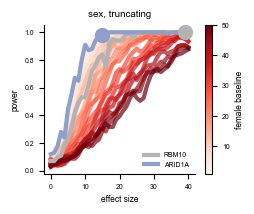

In [16]:
plot_power('is_male', 'truncating')